<a href="https://colab.research.google.com/github/elysecs/ML_Lab_FinalProject/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold
from sklearn.linear_model    import *
from sklearn.metrics         import *
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import *
from sklearn.base      import TransformerMixin, BaseEstimator
from sklearn.tree      import *
from imblearn          import FunctionSampler
from imblearn.pipeline import Pipeline as imbPipeline
from   sklearn.compose            import *
from   sklearn.ensemble           import *
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute             import *
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('bodega_solar_join.csv')

In [ ]:
X = df.iloc[:,2:]
y = df['MWh']

In [ ]:
# Remove null rows outside pipeline since target also needs to be transformed
def filter_data(X, y):
    "Filter data - remove from both X and y."
    # Remove rows with null solar radiation feature
    X1 = X[X['SOLARAD']!=999]
    y1 = y[X['SOLARAD']!=999]
    
    # Remove rows with " -9"
    X2 = X1[~((X1.T_HR_AVG.str.contains(' -9')) | (X1.T_MIN.str.contains(' -9')))]
    y2 = y1[~((X1.T_HR_AVG.str.contains(' -9')) | (X1.T_MIN.str.contains(' -9')))]
    
    convert_dict = {'T_HR_AVG': float, 
            'T_MAX': float,
            'T_MIN': float,
            'P_CALC': float, 
            'SOIL_MOISTURE_10': float,
            'SOIL_MOISTURE_100': float, 
            'SOIL_TEMP_5': float,
           } 
  
    X3 = X2.astype(convert_dict) 
    
    return X3, y2

In [ ]:
X_filtered, y_filtered = filter_data(X,y)

In [ ]:
X_train_all, X_test, y_train_all, y_test= train_test_split(X_filtered, y_filtered, test_size=.15, random_state=10) 
X_train, X_validation, y_train, y_validation= train_test_split(X_train_all, y_train_all, test_size=.15, random_state=10)

In [ ]:
algorithms = [ARDRegression(), BayesianRidge(), ElasticNet(), HuberRegressor(), 
 Lars(), Lasso(), LassoLars(), LassoLarsIC(), LinearRegression(),
 ElasticNet(), OrthogonalMatchingPursuit(), PassiveAggressiveRegressor(), 
 Ridge(), SGDRegressor(), TheilSenRegressor(),RandomForestRegressor(), 
 DecisionTreeRegressor(), ExtraTreeRegressor()]

In [ ]:
# Initial model search
d={}
for algo in algorithms:
    pipe = Pipeline([('lm',     algo)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
print(sorted( ((v,k) for k,v in d.items()))[:5])

[(742.3887254901962, 'RandomForestRegressor'),
 (950.5723622782447, 'DecisionTreeRegressor'),
 (998.9421101774043, 'ExtraTreeRegressor'),
 (1440.9002927188478, 'HuberRegressor'),
 (1603.9098367767551, 'Lars')]

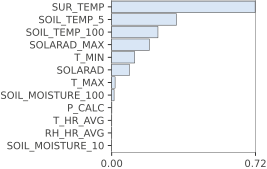

In [ ]:
# Suspect collinearity, Look at feature importance
# This seems weird, solar should be most important -> codependent features
lm = LinearRegression()
lm.fit(X_train_all, y_train_all)

from rfpimp import * # See https://explained.ai/rf-importance/index.html
I = importances(lm, X_train_all, y_train_all)
plot_importances(I)

In [ ]:
# Feature importance all variables
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train_all, y_train_all)
for col, imp in zip(X_train.columns,clf.feature_importances_):
    print(f'{col:<20} - {round(imp,3):^10}')

T_HR_AVG             -   0.005   
T_MAX                -   0.007   
T_MIN                -   0.008   
P_CALC               -   0.003   
SOLARAD              -   0.818   
SOLARAD_MAX          -   0.021   
SUR_TEMP             -   0.026   
RH_HR_AVG            -   0.041   
SOIL_MOISTURE_10     -   0.012   
SOIL_MOISTURE_100    -   0.008   
SOIL_TEMP_5          -   0.031   
SOIL_TEMP_100        -    0.02   


In [ ]:
# Remove extraneous features
non_corr_vars = ['SOLARAD', 'SUR_TEMP', 'T_HR_AVG','RH_HR_AVG','SOIL_MOISTURE_10','P_CALC']

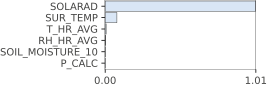

In [ ]:
# Remove soil moisture and precipitation variables
lm = LinearRegression()
lm.fit(X_train_all[non_corr_vars], y_train_all)

from rfpimp import * # See https://explained.ai/rf-importance/index.html
I = importances(lm, X_train_all[non_corr_vars], y_train_all)
plot_importances(I)

In [ ]:
# Feature importance with correlated variables removed
# Precipitation feature not very important
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train_all[non_corr_vars], y_train_all)
for col, imp in zip(X_train_all[non_corr_vars].columns,clf.feature_importances_):
    print(f'{col:<20} - {round(imp,3):^10}')

SOLARAD              -   0.838   
SUR_TEMP             -   0.045   
T_HR_AVG             -   0.029   
RH_HR_AVG            -   0.052   
SOIL_MOISTURE_10     -   0.033   
P_CALC               -   0.004   


In [ ]:
# Algs on subset of features
# MAE is worse but may be more general since model is not chasing noise??
d={}
for algo in algorithms:
    pipe = Pipeline([('lm',     algo)])

    pipe.fit(X_train[non_corr_vars], y_train)
    y_pred = pipe.predict(X_validation[non_corr_vars])
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
    #print(f"{algo.__class__.__name__:<17} - mean absolute error: {mae:,.2f}")
sorted( ((v,k) for k,v in d.items()))[:5]

[(870.8757708527856, 'RandomForestRegressor'),
 (1013.1610644257703, 'ExtraTreeRegressor'),
 (1117.2394957983192, 'DecisionTreeRegressor'),
 (1512.3579405641642, 'HuberRegressor'),
 (1764.8133853687484, 'PassiveAggressiveRegressor')]

In [ ]:
# Look at all features
# Scale all features, doesnt help forest algs
d={}
for algo in algorithms:
    pipe = Pipeline([('scaler', StandardScaler()),
                    ('lm',     algo)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((v,k) for k,v in d.items()))[:5]

[(744.7935620915033, 'RandomForestRegressor'),
 (938.750700280112, 'DecisionTreeRegressor'),
 (969.0345471521942, 'ExtraTreeRegressor'),
 (1400.0851484995803, 'PassiveAggressiveRegressor'),
 (1420.2764765720099, 'HuberRegressor')]

In [ ]:
X_train.columns

Index(['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC', 'SOLARAD', 'SOLARAD_MAX',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100'],
      dtype='object')

In [ ]:
# Scale everything but solar, doesnt change much
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',  #'SOLARAD', 'SOLARAD_MAX',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('scaler', StandardScaler())])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')

for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    print(f"{algo.__class__.__name__:<17} - mean absolute error: {mae:,.2f}")

RandomForestRegressor - mean absolute error: 741.41
HuberRegressor    - mean absolute error: 1,440.35


In [ ]:
# Scale solar, doesnt change much
num_columns = ['SOLARAD', 'SOLARAD_MAX']

num_pipe = Pipeline([('scaler', StandardScaler())])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')

for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    print(f"{algo.__class__.__name__:<17} - mean absolute error: {mae:,.2f}")

RandomForestRegressor - mean absolute error: 742.62
HuberRegressor    - mean absolute error: 1,438.31


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# Quantile Transform all features, no impact
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',  'SOLARAD', 'SOLARAD_MAX',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')

for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    print(f"{algo.__class__.__name__:<17} - mean absolute error: {mae:,.2f}")

RandomForestRegressor - mean absolute error: 743.76
HuberRegressor    - mean absolute error: 1,398.01


In [ ]:
# Quantile Transform non solar features, small decrease
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',  #'SOLARAD', 'SOLARAD_MAX',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')

for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    print(f"{algo.__class__.__name__:<17} - mean absolute error: {mae:,.2f}")

RandomForestRegressor - mean absolute error: 738.43
HuberRegressor    - mean absolute error: 1,432.10


In [ ]:
# Try binning Solar, look for best parameters
bin_columns = ['SOLARAD']
bin_pipe = Pipeline([('kbins', KBinsDiscretizer())])

preprocessing = ColumnTransformer([('bin', bin_pipe, bin_columns),
                                   ], remainder='passthrough')
pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('clf', RandomForestRegressor())
    ])

search_space = [{'clf': [RandomForestRegressor()],  # Actual Estimator
                 'preprocessing__bin__kbins__encode': ['onehot', 'onehot-dense', 'ordinal'],
                'preprocessing__bin__kbins__strategy': ['uniform', 'quantile', 'kmeans'],
                'preprocessing__bin__kbins__n_bins': [5,7,10],}]

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
cv = GridSearchCV(pipe, 
                search_space, 
                scoring='neg_mean_absolute_error',
                cv=rskf, 
                n_jobs=-1,
                verbose=1)
cv.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('bin',
                                                                         Pipeline(steps=[('kbins',
                                                                                          KBinsDiscretizer())]),
                                                                         ['SOLARAD'])])),
                                       ('clf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestRegressor()],
                          'preprocessing__bin__kbins__encode': ['onehot',
                                                                'onehot-dense',
                                                                'ordinal'],
      

In [ ]:
print(f'Best MAE-score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')

Best MAE-score: -709.928

Best parameter set: {'clf': RandomForestRegressor(), 'preprocessing__bin__kbins__encode': 'onehot-dense', 'preprocessing__bin__kbins__n_bins': 10, 'preprocessing__bin__kbins__strategy': 'kmeans'}



In [ ]:
# Binning doesn't help
bin_pipe = Pipeline([('kbins', KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='kmeans'))])
pipe = Pipeline([('preprocessing', preprocessing), 
                 ('lm',     RandomForestRegressor())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_validation)
mae = mean_absolute_error(y_validation, y_pred)
print(f"{'RF':<17} - mean absolute error: {mae:,.2f}")

RF                - mean absolute error: 760.20


In [ ]:
algs_subset = [HuberRegressor(), PassiveAggressiveRegressor(), RandomForestRegressor(),
       DecisionTreeRegressor(), ExtraTreeRegressor()]

In [ ]:
# Cross validation to find best model
for algo in algs_subset:
    from sklearn.model_selection import cross_val_score
    clf = algo
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    avg = np.mean(scores)
    print(f"{algo.__class__.__name__:<30} - avg mae: {avg:,.2f}")

HuberRegressor                 - avg mae: -1,456.11
PassiveAggressiveRegressor     - avg mae: -2,508.37
RandomForestRegressor          - avg mae: -708.19
DecisionTreeRegressor          - avg mae: -891.95
ExtraTreeRegressor             - avg mae: -980.61
PassiveAggressiveRegressor     - avg mae: -2,475.45


In [ ]:
# Hyperparameter search - Random Forest
hyperparameters = dict(n_estimators=[75,100,125], 
                       max_features=['auto','sqrt','log2'],
                       criterion=['mse','mae']
                       )
clf_grid = GridSearchCV(RandomForestRegressor(), 
                                    hyperparameters, 
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [75, 100, 125]},
             verbose=1)

In [ ]:
# Best parameters
print(f"The validation set accuracy - {clf_grid.score(X_validation, y_validation):.2%}")
print(f'Best score: {clf_grid.best_score_:.3f}')
print(f'Best parameter set: {clf_grid.best_params_}')

The validation set accuracy - 91.48%
Best score: 0.922

Best parameter set: {'criterion': 'mae', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 125}



In [ ]:
# Hyperparameter search - Extra Trees Forest
clf_grid = GridSearchCV(ExtraTreesRegressor(), 
                                    hyperparameters, 
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [75, 100, 125]},
             verbose=1)

In [ ]:
print(f"The validation set accuracy - {clf_grid.score(X_validation, y_validation):.2%}")
print(f'Best score: {clf_grid.best_score_:.3f}')
print(f'Best parameter set: {clf_grid.best_params_}')

The validation set accuracy - 91.92%
Best score: 0.926
Best parameter set: {'criterion': 'mae', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 75}


In [ ]:
# Try RF
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')


pipe = Pipeline([('preprocessing', preprocessing), 
                 ('rf',   RandomForestRegressor(criterion='mae',n_estimators=125))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_validation)
mae = mean_absolute_error(y_validation, y_pred)
print(f"{'RF':<17} - mean absolute error: {mae:,.2f}")

RF                - mean absolute error: 732.56


In [ ]:
# Try ExtraTrees - Final Model
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')


pipe = Pipeline([('preprocessing', preprocessing), 
                 ('rf',   ExtraTreesRegressor(criterion='mae',n_estimators=75))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_validation)
mae = mean_absolute_error(y_validation, y_pred)
print(f"{'RF':<17} - mean absolute error: {mae:,.2f}")

RF                - mean absolute error: 716.77


In [ ]:
# Test Data
pipe.fit(X_train_all, y_train_all)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"{'RF':<17} - mean absolute error: {mae:,.2f}")

RF                - mean absolute error: 695.32
